## Overview

In this tutorial, we will build a simple aritificial neural network (ANN), also known as multilayer perceptron (MLP) or feedforward neural network (FNN). The learning outcomes are:
1. Understand how the model is formulated mathematically;
2. Understand what is meant by training the network;
3. Experiment with more complex architectures.

## Data

We generate data from a Gaussian process with a specified covariance matrix. The details of data generation do not matter as in reality, you never know the actual data generation machanism.

**The key** here is that we want to predict $y \in R^5$ given the previous values $x\in R^{25}$.

In [1]:
# first let's generate data, you can ignore this part
import numpy as np
import sys
import os
sys.path.insert(1, '..')
os.chdir('..')

from data_formatters.iglu import *
from dataset import TSDataset
from conf import Conf


cnf = Conf(conf_file_path='./conf/iglu.yaml', seed=15, exp_name="IGLU", log=False)
data_formatter = IGLUFormatter(cnf)
# set up torch dataset
import torch
from torch.utils.data import TensorDataset
train_idx, test_idx, val_idx = map(set, data_formatter.split_data())
train, test, val = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for index, row in data_formatter.data.iterrows():
    if index in train_idx:
        train.append(row)
    elif index in test_idx:
        test.append(row)
    else:
        val.append(row)

# These are empty for some reason
print(train, test, val)
x_columns = ["time"]
y_columns = ["gl"]
train_x, test_x, val_x, = map(lambda x: x[x_columns], [train, test, val])
train_y, test_y, val_y, = map(lambda x: x[y_columns], [train, test, val])

train_dataset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_dataset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
val_dataset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
# set up torch dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Dropped segments: 13
Extracted segments: 19


C:\Users\bunu_\AppData\Local\Temp\ipykernel_34412\2896344539.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train.append(row)
C:\Users\bunu_\AppData\Local\Temp\ipykernel_34412\2896344539.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train.append(row)
C:\Users\bunu_\AppData\Local\Temp\ipykernel_34412\2896344539.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train.append(row)
C:\Users\bunu_\AppData\Local\Temp\ipykernel_34412\2896344539.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train.append(row)
C:\Users\bunu_\AppData\Local\Temp\ipykernel_34412\2896344539.py:23: FutureWarning: The frame.append method is deprec

Empty DataFrame
Columns: []
Index: []


KeyError: "None of [Index(['time'], dtype='object')] are in the [columns]"

## Linear regression

Suppose we want to model our data as a linear transformation, that is we aim to find $W \in R^{25\times 5}$ so that to minimize the squared error between the prediction and the truth. In summary, we formulate the problem as:
$$
W^* = \argmin_{W} || Y -  XW ||^2
$$

This model is an extension of the model many of us have covered in the introductory statisics courses to a multivariate case. **Recall** that for one-dimensional case (i.e. when $y \in R$) and under some distributional assumptions, this optimization problem has a closed form solution that is guaranteed to be the best (BLUE). When we move to more dimensions and start relaxing the assumptions, we no longer have the closed-form solution. Hence, we need to resort to the apprximate methods. Below, we program the model and see its performance.

In [ ]:
import torch
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1)
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [ ]:
# train model
best_loss = 1e10
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))
    

Epoch [1/100], Loss: 1.0301
Epoch [1/100], Val Loss: 1.5124
Epoch [2/100], Loss: 1.2070
Epoch [2/100], Val Loss: 1.4371
Epoch [3/100], Loss: 1.1392
Epoch [3/100], Val Loss: 1.4223
Epoch [4/100], Loss: 1.0849
Epoch [4/100], Val Loss: 1.3971
Epoch [5/100], Loss: 0.9695
Epoch [5/100], Val Loss: 1.4095
Epoch [6/100], Loss: 0.9850
Epoch [6/100], Val Loss: 1.3964
Epoch [7/100], Loss: 1.0584
Epoch [7/100], Val Loss: 1.3969
Epoch [8/100], Loss: 0.8272
Epoch [8/100], Val Loss: 1.4101
Epoch [9/100], Loss: 0.9449
Epoch [9/100], Val Loss: 1.4174
Epoch [10/100], Loss: 0.9227
Epoch [10/100], Val Loss: 1.4050
Epoch [11/100], Loss: 0.9730
Epoch [11/100], Val Loss: 1.4123
Epoch [12/100], Loss: 0.9394
Epoch [12/100], Val Loss: 1.4085
Epoch [13/100], Loss: 1.1671
Epoch [13/100], Val Loss: 1.4155
Epoch [14/100], Loss: 0.9672
Epoch [14/100], Val Loss: 1.4012
Epoch [15/100], Loss: 0.9054
Epoch [15/100], Val Loss: 1.3962
Epoch [16/100], Loss: 1.1542
Epoch [16/100], Val Loss: 1.3974
Epoch [17/100], Loss: 1.04

<All keys matched successfully>

In [ ]:
# evaluate model on test set
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 1.0417


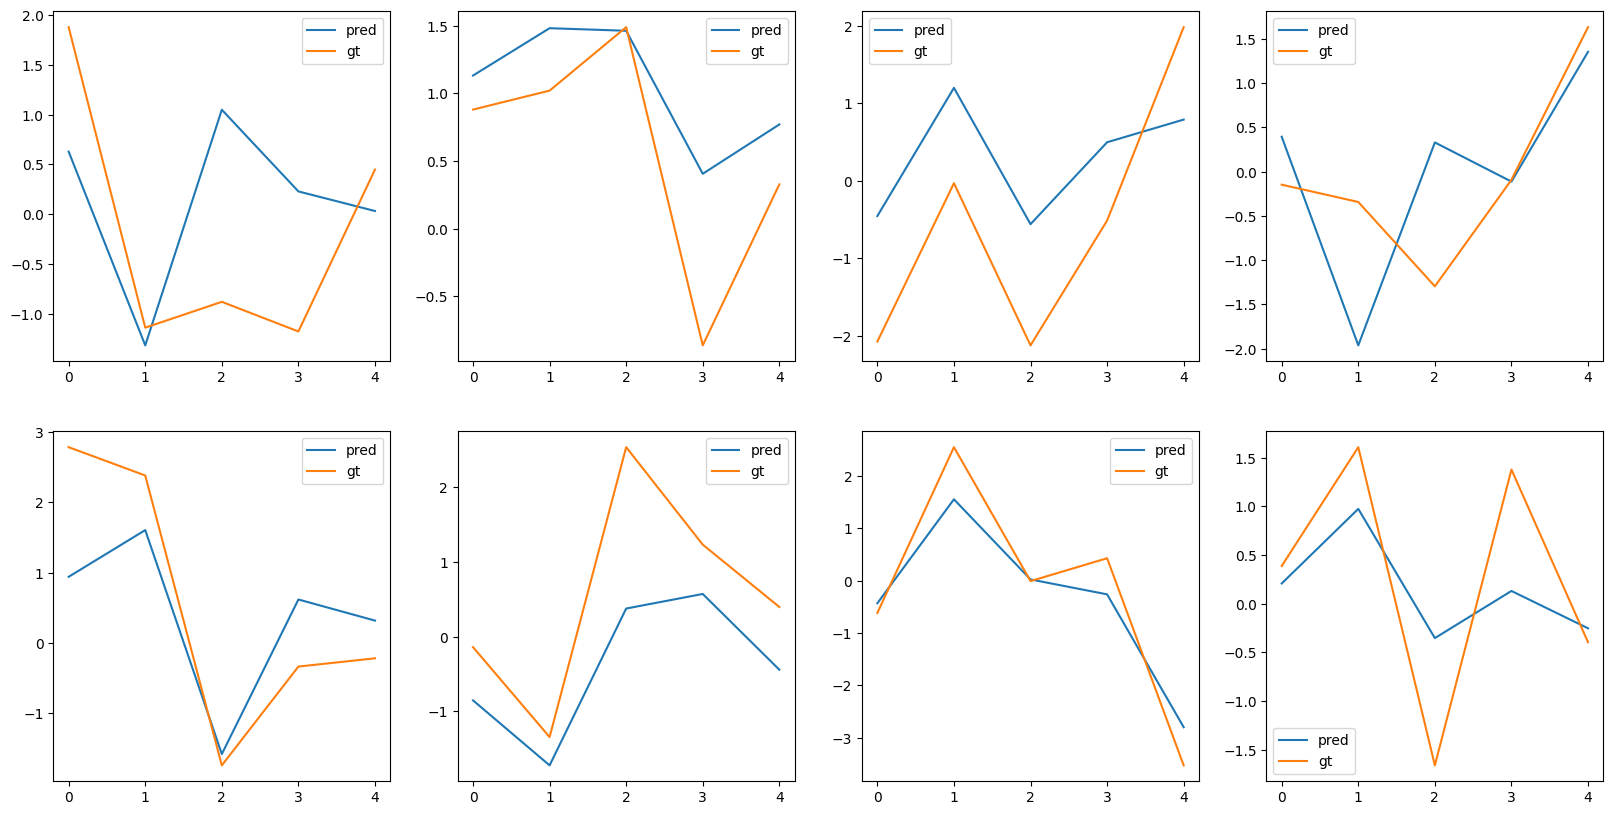

In [ ]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## Can we do better?

In our case, there is little justification to move beyond the linear regression setting because of how the data is generated. Nevertheless, nobody is stopping us from trying. Let's now formulate our model as: $$\hat y  = (ReLU(XW^{(1)})) W^{(2)},$$
where $W^{(1)} \in R^{25 \times n_1}, W^{(2)} \in R^{n_1 \times 5}$ are learnable weight matrie and $n_1$ is a hyper-parameter we get to choose.

The main points we want to you to notice from this example are:
1. More complex models do not mean better performance;
2. Hyper-parameter tuning is tedious;
3. **Most importantly**, we can learn any differentiable architecture with the help of SGD.

In [ ]:
# define model
import torch
class MLP(torch.nn.Module):
    def __init__(self, n1):
        super(MLP, self).__init__()
        self.linear = torch.nn.Linear(25, n1)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(n1, 5)
        
    def forward(self, x):
        y_pred = self.linear2(self.relu(self.linear(x)))
        return y_pred

In [ ]:
# train model
best_loss = 1e10
model = MLP(100)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model.pth')
# load best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch [1/100], Loss: 1.1998
Epoch [1/100], Val Loss: 1.7867
Epoch [2/100], Loss: 0.9580
Epoch [2/100], Val Loss: 1.5956
Epoch [3/100], Loss: 0.9036
Epoch [3/100], Val Loss: 1.5475
Epoch [4/100], Loss: 1.0259
Epoch [4/100], Val Loss: 1.5146
Epoch [5/100], Loss: 0.9335
Epoch [5/100], Val Loss: 1.5035
Epoch [6/100], Loss: 0.8060
Epoch [6/100], Val Loss: 1.4930
Epoch [7/100], Loss: 0.9824
Epoch [7/100], Val Loss: 1.5029
Epoch [8/100], Loss: 0.9577
Epoch [8/100], Val Loss: 1.4861
Epoch [9/100], Loss: 0.9473
Epoch [9/100], Val Loss: 1.4862
Epoch [10/100], Loss: 1.1394
Epoch [10/100], Val Loss: 1.5076
Epoch [11/100], Loss: 1.0321
Epoch [11/100], Val Loss: 1.4982
Epoch [12/100], Loss: 0.9005
Epoch [12/100], Val Loss: 1.5141
Epoch [13/100], Loss: 0.9325
Epoch [13/100], Val Loss: 1.5108
Epoch [14/100], Loss: 1.0244
Epoch [14/100], Val Loss: 1.5011
Epoch [15/100], Loss: 1.0518
Epoch [15/100], Val Loss: 1.5042
Epoch [16/100], Loss: 1.0010
Epoch [16/100], Val Loss: 1.5226
Epoch [17/100], Loss: 0.94

<All keys matched successfully>

In [ ]:
# evaluate model on test set
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [100/100], Test Loss: 1.0556


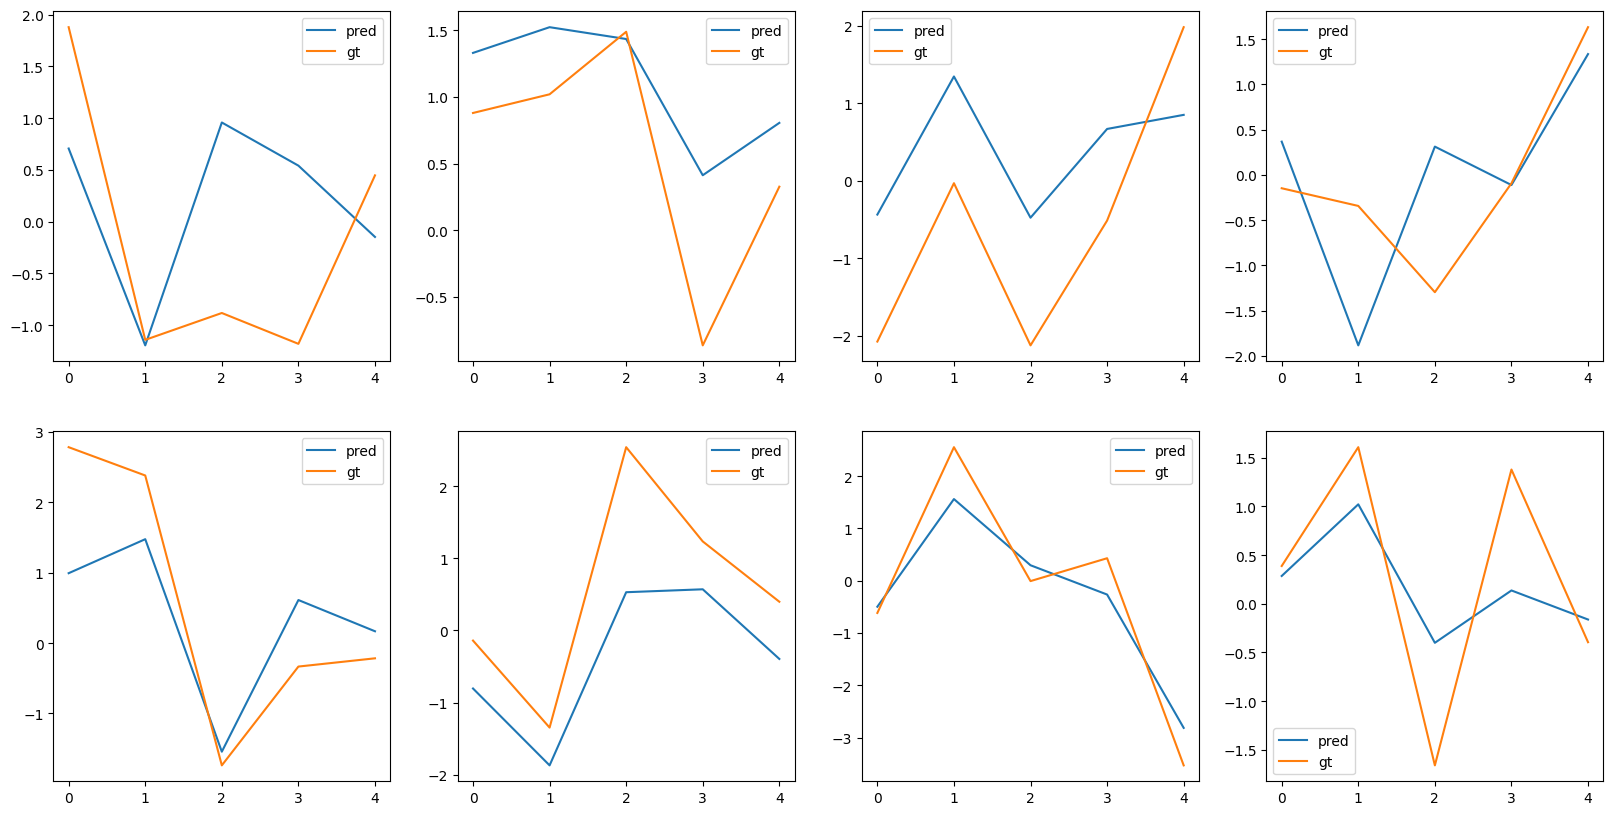

In [ ]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()